## Clustering

Clustering is a type of __unsupervised machine learning__, where different data points are grouped together into two or more clusters. Data points in the same cluster are more similar to each other than those in other clusters. This __similarity__ can be measured in some specified way and the strength of similarity between data points is used to assign data points to its cluster. 

There are hard or soft clustering methods. Hard clustering is when each data point belongs to a cluster completely. Soft clustering is when each data point can belong to more than one cluster with some probability. The number of clusters can be defined by the user. However, in some cases even the users do not know how many clusters should the data be grouped into. Therefore, figuring out the best number of cluster is also a part of the clustering task.  

### K-Means Clustering
* A centroid-based clustering method. 
* Given a cluster, a __centroid__ is its central data point. 
* Centroid can be real of imaginary. 
* In K-Means an iterative algorithm is employed to derive similarity based on the distance of that data point from the centroid of the cluster. 

Let's begin by downloading a small sample (version 2) of marketing campaign dataset of a Portugese banking institution available on [OpenML](https://www.openml.org/). The data is related to direct marketing campaigns via phone calls to subscribe clients to a bank term deposit. Detailed description of the dataset is available [here](https://www.openml.org/d/1461). 

We will use the `fetch_openml` function from `datasets` module of sklearn. The function provides easy access to the OpenML API to download available datasets.

In [45]:
from sklearn.datasets import fetch_openml

# fetch by using data name and version
bank_marketing = fetch_openml(name='bank-marketing', version=2) # try version 1

# prepare feature matrix and target data 
X = bank_marketing.data 

Let's take a quick look at the data.

In [2]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,30.0,unemployed,married,primary,no,1787.0,no,no,cellular,19.0,oct,79.0,1.0,-1.0,0.0,unknown
1,33.0,services,married,secondary,no,4789.0,yes,yes,cellular,11.0,may,220.0,1.0,339.0,4.0,failure
2,35.0,management,single,tertiary,no,1350.0,yes,no,cellular,16.0,apr,185.0,1.0,330.0,1.0,failure
3,30.0,management,married,tertiary,no,1476.0,yes,yes,unknown,3.0,jun,199.0,4.0,-1.0,0.0,unknown
4,59.0,blue-collar,married,secondary,no,0.0,yes,no,unknown,5.0,may,226.0,1.0,-1.0,0.0,unknown


Each row of the feature matrix `X` belongs to a bank client. Each column provides additional details related to that client including data from the last contact of the current campaign. We do not have column names to identify them easily. So let's add them to the data set.

In [4]:
X.columns = ['age', 'job', 'marital_status', 'education', 'credit_default', 'balance', 'housing', 'loan', 
             'lastcontact_type', 'lastcontact_dayofmonth', 'lastcontact_month', 'lastcontact_duration', 
             'n_contacts', 'days_since_lastcontact', 'previous_n_contacts', 'previous_outcome']
X.head()

,age,job,marital_status,education,credit_default,balance,housing,loan,lastcontact_type,lastcontact_dayofmonth,lastcontact_month,lastcontact_duration,n_contacts,days_since_lastcontact,previous_n_contacts,previous_outcome
0,30.0,unemployed,married,primary,no,1787.0,no,no,cellular,19.0,oct,79.0,1.0,-1.0,0.0,unknown
1,33.0,services,married,secondary,no,4789.0,yes,yes,cellular,11.0,may,220.0,1.0,339.0,4.0,failure
2,35.0,management,single,tertiary,no,1350.0,yes,no,cellular,16.0,apr,185.0,1.0,330.0,1.0,failure
3,30.0,management,married,tertiary,no,1476.0,yes,yes,unknown,3.0,jun,199.0,4.0,-1.0,0.0,unknown
4,59.0,blue-collar,married,secondary,no,0.0,yes,no,unknown,5.0,may,226.0,1.0,-1.0,0.0,unknown


Our task is to figure out how to devise a marketing campaign to optimize client subscription to bank term deposit. 

The data is not ready to feed into a ML algorithm. Therefore, we need to perform various __data cleaning__ or __data pre-processing__ steps before implementing our algorithm of choice to solve this task. 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     4521 non-null   float64 
 1   job                     4521 non-null   category
 2   marital_status          4521 non-null   category
 3   education               4521 non-null   category
 4   credit_default          4521 non-null   category
 5   balance                 4521 non-null   float64 
 6   housing                 4521 non-null   category
 7   loan                    4521 non-null   category
 8   lastcontact_type        4521 non-null   category
 9   lastcontact_dayofmonth  4521 non-null   float64 
 10  lastcontact_month       4521 non-null   category
 11  lastcontact_duration    4521 non-null   float64 
 12  n_contacts              4521 non-null   float64 
 13  days_since_lastcontact  4521 non-null   float64 
 14  previous_n_contacts     

There are no missing values in this datasets. However, there are many `categorical` data types which have "unknown" values and could be treated the same way. These categorical data need to be converted into numeric so that ML algorithm implementation tools can accept them. 

For now, we will use all categories available including "unknown". However, I encourage you to look at these categories closely and find new ways of dealing with them such that model performance can perhaps be improved.

To convert categorical data into numeric we can use the [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) object from the `preprocessing` module of sklearn. The function follows a `fit_transform` framework used in many other sklearn objects. Given a dataset, the encoder finds the unique categories for each feature and transforms them into a new column, where a value of 1 is given if the row belongs to that category or 0 otherwise. This process is also known as __vector representation__.  

__Note__ that `pandas` also offers a method called `get_dummies`, which converts categorical variables into dummy variables much the same way.

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
# make a list of categorical columns and isolate these features
cat_feat = ['job', 'marital_status', 'education', 'credit_default', 'housing', 'loan', 
             'lastcontact_type', 'lastcontact_month', 'previous_outcome']
X_cat = X[cat_feat]
X_cat.head()

,job,marital_status,education,credit_default,housing,loan,lastcontact_type,lastcontact_month,previous_outcome
0,unemployed,married,primary,no,no,no,cellular,oct,unknown
1,services,married,secondary,no,yes,yes,cellular,may,failure
2,management,single,tertiary,no,yes,no,cellular,apr,failure
3,management,married,tertiary,no,yes,yes,unknown,jun,unknown
4,blue-collar,married,secondary,no,yes,no,unknown,may,unknown


In [9]:
# create and instance of OneHotEncoder
enc = OneHotEncoder()

# apply fit_transform on dataframe with categorical features only 
X_cat_ohe = enc.fit_transform(X_cat)

# convert result into numpy array
X_cat_ohe = X_cat_ohe.toarray()

# convert result into pandas dataframe
X_cat_ohe = pd.DataFrame(X_cat_ohe)

# rename columns
X_cat_ohe.columns = enc.get_feature_names(cat_feat)
X_cat_ohe.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,lastcontact_month_jun,lastcontact_month_mar,lastcontact_month_may,lastcontact_month_nov,lastcontact_month_oct,lastcontact_month_sep,previous_outcome_failure,previous_outcome_other,previous_outcome_success,previous_outcome_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The categorical data is now in an acceptable format. Let's drop the orginal columns and add these columns instead in the feature matrix. 

In [10]:
X.drop(cat_feat, axis=1, inplace=True)
X = pd.concat([X, X_cat_ohe], axis=1)
X.head()

C:\Users\niti.mishra\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,age,balance,lastcontact_dayofmonth,lastcontact_duration,n_contacts,days_since_lastcontact,previous_n_contacts,job_admin.,job_blue-collar,job_entrepreneur,...,lastcontact_month_jun,lastcontact_month_mar,lastcontact_month_may,lastcontact_month_nov,lastcontact_month_oct,lastcontact_month_sep,previous_outcome_failure,previous_outcome_other,previous_outcome_success,previous_outcome_unknown
0,30.0,1787.0,19.0,79.0,1.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,33.0,4789.0,11.0,220.0,1.0,339.0,4.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,35.0,1350.0,16.0,185.0,1.0,330.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,30.0,1476.0,3.0,199.0,4.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,59.0,0.0,5.0,226.0,1.0,-1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


For example purposes, I will now only select a few features to show an implementation of K-Means algorithm.

In [16]:
slctd_cols = ['age', 'balance', 'n_contacts', 'days_since_lastcontact',
              'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
              'job_management', 'job_retired', 'job_self-employed', 'job_services',
              'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
              'education_primary', 'education_secondary',
              'education_tertiary', 'education_unknown', 
              'credit_default_no', 'credit_default_yes', 
              'housing_no','housing_yes', 
              'loan_no', 'loan_yes',
              'previous_outcome_failure', 'previous_outcome_other', 
              'previous_outcome_success', 'previous_outcome_unknown']
X_select = X[slctd_cols]

Now we can use the `fit_predict` framework of sklearn to implement the [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering algorithm in this data. This framework will train the model using provided data and then obtain subsequent predictions. 

In [36]:
from sklearn.cluster import KMeans

In [37]:
k_means = KMeans(n_clusters=2, init='random', random_state=0)
y_pred = k_means.fit_predict(X_select)

The parameter `n_cluster` takes the value of the number of clusters we wish to have. Here we have asked the data to be grouped into two clusters. The parameter `init` refers to the method to be used for initialization of the K-Means algorithm. We also specify the `random_state` parameter to replicate the result. 

### Evaluation

### Elbow Method

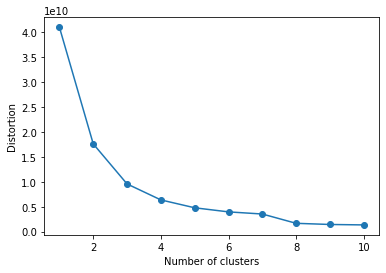

In [22]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_select)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()